# SIMPL demo 

This demo loads an artificial dataset (the grid cell dataset of figure 3) and train SIMPl to recover the underlying latent space. It serves to 

## Load and prepare data
SIMPL API requires users to provide spikes, an initial latent variable, and time stamps. 
Optionally, if you have them, you can also provide the ground truth latent variables such as the _true_ latent variables and the _true_ spikes, but onlyif you have them. Here we will assume you dont s oyuo can 


In [1]:
# Standard imports
import numpy as np 
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt

# SIMPL
from simpl.utils import load_datafile, prepare_data
from simpl.environment import Environment
from simpl.simpl import SIMPL

# A seperate package, KalMax, handles backend kalman filtering and KDE estimation
import kalmax 

Load some premade artificial data:

In [2]:
data = load_datafile('gridcelldata.npz')

print('Required data:')
Y = data['Y']; print(f'   {"Y, spikes:": <30}{Y.shape}')
Xb = data['Xb']; print(f'   {"Xb, latent initialisation:": <30}{Xb.shape}')
time = data['time']; print(f'   {"time, time stamps:": <30}{time.shape}')

# optionally, if you have the ground truth trajcetory and tuning curves you can use these too 
print('\nOptional ground truth data and other coordinates. You DONT need to have these:')
Xt = data['Xt']; print(f'   {"Xt, ground truth:": <30}{Xt.shape}')
dims = data['dim']; print(f'   {"dim, dimension names:": <30}{dims.shape}')
neuron = data['neuron']; print(f'   {"neuron, neuron IDs:": <30}{neuron.shape}')
Ft = data['Ft']; print(f'   {"Ft, tuning curves:": <30}{Ft.shape}')
xbins = data['x']; print(f'      {"xbins:": <27}{xbins.shape}')
ybins = data['y']; print(f'      {"ybins:": <27}{ybins.shape}')

Required data:
   Y, spikes:                    (36000, 225)
   Xb, latent initialisation:    (36000, 2)
   time, time stamps:            (36000,)

Optional ground truth data and other coordinates. You DONT need to have these:
   Xt, ground truth:             (36000, 2)
   dim, dimension names:         (2,)
   neuron, neuron IDs:           (225,)
   Ft, tuning curves:            (225, 100, 100)
      xbins:                     (100,)
      ybins:                     (100,)


SIMPL requires these to be converted to xarrays and compiled as an xarray.Dataset. We provide a helper function for this: 

In [3]:
data = prepare_data(
    Y=Y, 
    Xb=Xb,
    time=time, 

    # Optional arguments
    # dims = dims,
    # neurons=neuron,
    # Xt=Xt,
    # Ft=Ft,
    # Ft_coords_dict={'x': xbins, 'y': ybins}
)
data

<xarray.Dataset> Size: 9MB
Dimensions:  (time: 36000, neuron: 225, dim: 2)
Coordinates:
  * time     (time) float64 288kB 0.1 0.2 0.3 0.4 ... 3.6e+03 3.6e+03 3.6e+03
  * neuron   (neuron) int64 2kB 0 1 2 3 4 5 6 7 ... 218 219 220 221 222 223 224
  * dim      (dim) int64 16B 0 1
Data variables:
    Y        (time, neuron) bool 8MB False False False ... False True False
    Xb       (time, dim) float64 576kB 0.738 0.6502 0.7442 ... 0.1244 0.6295

## Prepare the environment

SIMPL requires you to make an `Environment` object. This contains a number of attributes but, in essence, creates a discretised hyperrectangular environment inside which the latent variables are defined.

`DX`, the environment gridscale, determines the bin size. Tuning curves are estimated over all bins in the environment so computational cost should scale like ($\frac{1}{N_{\textrm{bins}}}^{D}).
In practice the algorithm is not as sensitive to this parameter as one might expect and position decoding is still fully-continuous.

In [4]:
PAD = 0.0 # any extra room to add to the edges of the environment around the data
DX = 0.02
env = Environment(
    X = data.Xb.values, # data is only needed here to calculate the required size and number of dimensions
    pad = PAD, # padding (in meters) for the latent space outside the data bounds 
    bin_size = DX, # bin size in meters
)

Created a 2D cuboid environment with dimensions ['x', 'y'] and discretised shape (50, 50)
Environment limits are ((np.float64(0.0), np.float64(0.0)), (np.float64(1.0), np.float64(1.0)))
The coords of each dimension are stored in self.coords_dict and a list of combined ['x', 'y'] coords for all bins is stored in self.discretised_coords


## Create the SIMPL model 

SIMPL takes in `data` and `env` as arguments and optionally a small number of other parameters listed here so you can see what they are and play around with them if you wish:

In [5]:
kernel = kalmax.kernels.gaussian_kernel
kernel_bandwidth = 0.02 # bandwidth of the KDE kernel in meters for fitting the tuning curves
observation_noise_std = 0.04 #additional kalman observation noise (ontop of likelihood gaussian width, see paper)
speed_prior = 0.4 # prior on the speed of the animal in meters per second
test_frac = 0.1 # fraction of spikes to withold as test set
speckle_block_size_seconds = 1 # block size for speckle noise in seconds
manifold_align_against = 'behaviour' # whether or not to linearly align the latent against behaviour on each iteration
evaluate_each_epoch = True # whether or not to do a full evaluation of the model after each epoch (bit slower but not much)
save_likelihood_maps = False # whether or not to save likelihood maps for each timestep (lots of memory, on do this if you really need them) 

In [6]:
simpl_model = SIMPL(
    data = data,
    environment = env,
    # Optional 
    kernel = kernel,
    kernel_bandwidth = kernel_bandwidth,
    observation_noise_std = observation_noise_std,
    speed_prior = speed_prior,
    test_frac = test_frac,
    speckle_block_size_seconds = speckle_block_size_seconds,
    manifold_align_against = manifold_align_against,
    evaluate_each_epoch = evaluate_each_epoch,
    save_likelihood_maps = save_likelihood_maps,
)

## Train the SIMPL model 


In [7]:
# used ground truth Xt and Ft to calculate some baseline metrics such as the log-likelihood of the spikes under the ground truth tuning curves/trajectory
simpl_model.calculate_baselines()

/Users/tomgeorge/Documents/UCL/rNEM/simpl/simpl.py:581: UserWarning: Ground truth data not available, so the baselines cannot be calculated.
  warnings.warn("Ground truth data not available, so the baselines cannot be calculated.")


In [8]:
# Trains the model for N epochs 
simpl_model.train_N_epochs(N=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4: Train LL: -0.072 (Δ0.123), Test LL: -0.076 (Δ0.145): 100%|██████████| 5/5 [00:27<00:00,  5.48s/it]


## Extract the results 

All the results are stored in a big xarray.Dataset object. There's a lot of stuff in there and all the coordinates come included so it should be fairly straightforward to use this to generate whatever plots you are interested in

Note epochs -1 and -2 (if present) represent the "baselines". They are two subtely different versions of the ground truth (see the source code for details)

If you are unsure what a quantity represents you can always check its meta data stored within the xarray object.

The most important results are: 

- `rnem.results.F`: tuning curves across epochs
- `rnem.results.X`: inferred latent variables across epochs
- `rnem.results.logPYXF`: log likelihood of the data given the inferred latent variables and tuning curves
- `rnem.results.Xt`: ground truth latent variables
- `rnem.results.Ft`: ground truth tuning curves

In [9]:
results = simpl_model.results

### Plot latent at epochs 0, 1, 2,... alongside the true latent (if available)

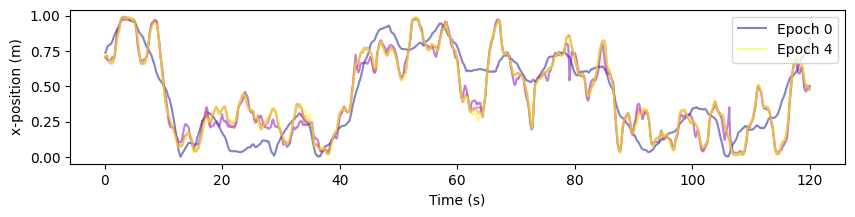

In [10]:
timeslice = slice(0, 120)
t = results.time.sel(time=timeslice).values

fig, ax = plt.subplots(1, 1, figsize=(10, 2))
for epoch in range(0, results.epoch.values[-1]+1):
    X = results.X.sel(epoch=epoch,time=timeslice).values
    ax.plot(t, X[:,0], color=matplotlib.cm.plasma(epoch/results.epoch.values[-1]), alpha=0.5, label = (f'Epoch {epoch}' if epoch in [0, results.epoch.values[-1]] else None))

if 'Xt' in results.keys():
    XT = results.Xt.sel(time=timeslice).values
    ax.plot(t,  XT[:,0], 'k', ls='--',label='Ground truth')
ax.set_xlabel('Time (s)')
ax.set_ylabel('x-position (m)')
ax.legend()

### Plot the receptive field of one of the neurons at epoch 0, 1, 2,... alongside the true receptive field

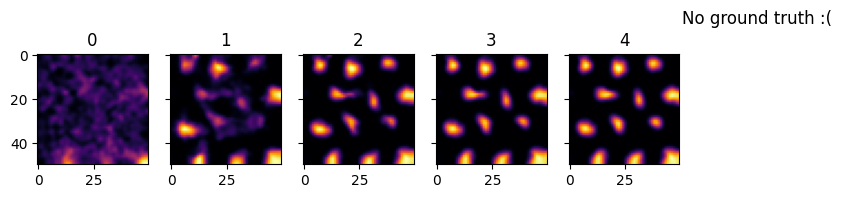

In [11]:
fig, ax = plt.subplots(1, results.epoch.values[-1]+2, figsize=(10, 2), sharex=True, sharey=True)
for epoch in range(0, results.epoch.values[-1]+1):
    F = results.F.sel(epoch=epoch, neuron=10)
    ax[epoch].imshow(F, cmap='inferno')
    ax[epoch].set_title(f'{epoch}')
    # edge_map = results.place_field_outlines.sel(epoch=epoch, neuron=10).values[::-1].astype(float)
    # edge = ax[epoch].imshow(edge_map,extent=env.extent, cmap='Greys_r', alpha=edge_map,zorder=10)
    
if 'Ft' in results.keys():
    FT = results.Ft.sel(neuron=10)
    ax[-1].imshow(FT, cmap='inferno')
    ax[-1].set_title('Ground truth')
else:
    ax[-1].set_title('No ground truth :(')
    ax[-1].axis('off')

# TODO fix why ground truth is reflected 

### Print the log-likelihood spikes at each epoch


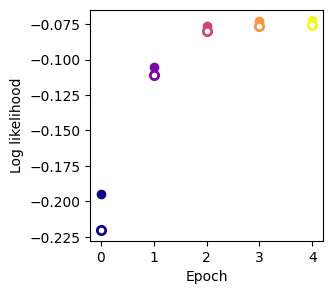

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
for i in range(0, results.epoch.values[-1]+1):
    ax.scatter(results.epoch[i], results.logPYXF.sel(epoch=i), label=f'Epoch {i}', color=matplotlib.cm.plasma(i/results.epoch.values[-1]))
    ax.scatter(results.epoch[i], results.logPYXF_test.sel(epoch=i), label=f'Epoch {i}', color='w', edgecolors=matplotlib.cm.plasma(i/results.epoch.values[-1]), linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log likelihood')
if -1 in results.epoch.values:
    ax.axhline(results.logPYXF.sel(epoch=-1), color='k', ls='--', label='Ground truth')


